In [173]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


In [174]:
df = pd.read_csv("cinemaTicket_Ref.csv")
df.head(5)

,film_code,cinema_code,total_sales,tickets_sold,tickets_out,show_time,occu_perc,ticket_price,ticket_use,capacity,date,month,quarter,day
0,1492,304,3900000,26,0,4,4.26,150000.0,26,610.328638,2018-05-05,5,2,5
1,1492,352,3360000,42,0,5,8.08,80000.0,42,519.801980,2018-05-05,5,2,5
2,1492,489,2560000,32,0,4,20.00,80000.0,32,160.000000,2018-05-05,5,2,5
3,1492,429,1200000,12,0,1,11.01,100000.0,12,108.991826,2018-05-05,5,2,5
4,1492,524,1200000,15,0,3,16.67,80000.0,15,89.982004,2018-05-05,5,2,5


In [175]:
# Creating a new ID code for cinemas and film code

df["unique_id"] = df[["film_code", "cinema_code", "date"]].apply(
    lambda row: "_".join(row.values.astype(str)), axis=1
)
# Move to first column the column "Unique id"
df = df[["unique_id"] + [col for col in df.columns if col != "unique_id"]]


##### I) Data expLoration


In [176]:
df.info()
# The date column has object type, we gonna change this type

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142524 entries, 0 to 142523
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   unique_id     142524 non-null  object 
 1   film_code     142524 non-null  int64  
 2   cinema_code   142524 non-null  int64  
 3   total_sales   142524 non-null  int64  
 4   tickets_sold  142524 non-null  int64  
 5   tickets_out   142524 non-null  int64  
 6   show_time     142524 non-null  int64  
 7   occu_perc     142399 non-null  float64
 8   ticket_price  142524 non-null  float64
 9   ticket_use    142524 non-null  int64  
 10  capacity      142399 non-null  float64
 11  date          142524 non-null  object 
 12  month         142524 non-null  int64  
 13  quarter       142524 non-null  int64  
 14  day           142524 non-null  int64  
dtypes: float64(3), int64(10), object(2)
memory usage: 16.3+ MB


In [177]:
df["date"] = pd.to_datetime(df["date"], dayfirst=True, format=r"%Y-%m-%d")


In [178]:
df.head()


,unique_id,film_code,cinema_code,total_sales,tickets_sold,tickets_out,show_time,occu_perc,ticket_price,ticket_use,capacity,date,month,quarter,day
0,1492_304_2018-05-05,1492,304,3900000,26,0,4,4.26,150000.0,26,610.328638,2018-05-05,5,2,5
1,1492_352_2018-05-05,1492,352,3360000,42,0,5,8.08,80000.0,42,519.801980,2018-05-05,5,2,5
2,1492_489_2018-05-05,1492,489,2560000,32,0,4,20.00,80000.0,32,160.000000,2018-05-05,5,2,5
3,1492_429_2018-05-05,1492,429,1200000,12,0,1,11.01,100000.0,12,108.991826,2018-05-05,5,2,5
4,1492_524_2018-05-05,1492,524,1200000,15,0,3,16.67,80000.0,15,89.982004,2018-05-05,5,2,5


In [179]:
def nulls(df, df_name):

    if df.isnull().values.any() == False:
        print(f"NULLS: There isn't null values in:{df_name}")

    else:
        print("NULLS: There is nulls values")
        null_columns = df.columns[df. isnull().any()].tolist()

        for column in null_columns:
            nulls = df[column].isna().sum()
            percent = round((nulls / len(df)), 4) * 100
            print(
                f" [{column}] has:  nulls number: {nulls} | nulls % : {percent}%"
            )


def duplicates(df, column):
    num_dup = df.duplicated(subset=[column]).sum()
    
    if df.duplicated(subset=[column]).sum() != 0:
        a = df.duplicated(subset=[column]).sum()
        print(f"There are '{a}' duplicated values:")


<Figure size 1200x400 with 0 Axes>

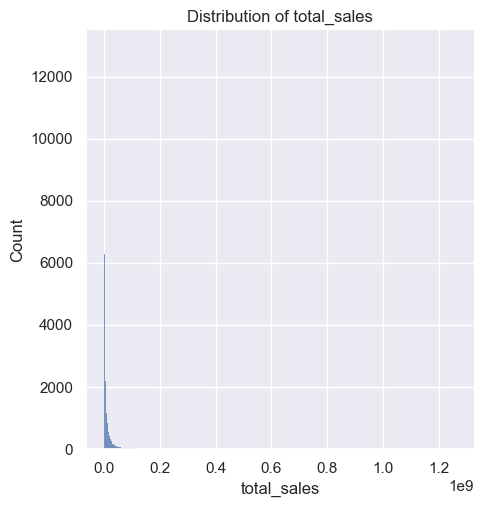

In [180]:
def visual_distr(df, col):
    
    variable=df[col].values
    plt.figure(figsize=(12,4))
    sns.displot(variable)
    plt.title(f'Distribution of {col}')
    plt.xlabel(f"{col}")
    
    return plt.show()

visual_distr(df,"total_sales")


##### 1) Preprocessing


1260000.0 11100000.0
lower-bound:-13500000.0 
 upper-bound:25860000.0


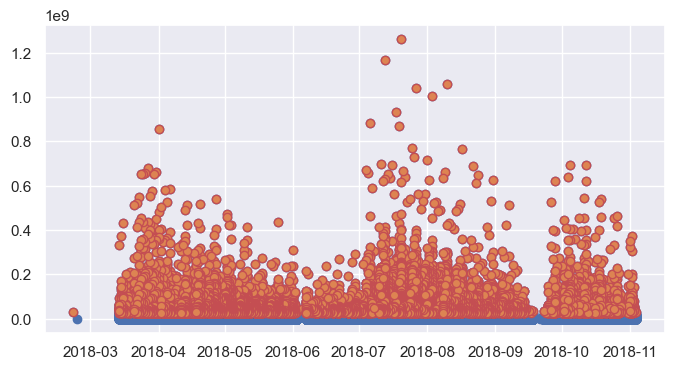

In [181]:
quantile1, quantile3= np.percentile(df['total_sales'], [25,75])
print(quantile1,quantile3)

iqr_value=quantile3-quantile1

lower_bound = quantile1 - (1.5 * iqr_value)
upper_bound = quantile3 + (1.5 * iqr_value)

print(f"lower-bound:{lower_bound}", "\n", f"upper-bound:{upper_bound}")

plt.figure(figsize=(8,4))
plt.scatter(df.values[:,11], df.values[:,3])
ub_date=df[df['total_sales'] > upper_bound].values[:,11]
ub_sales=df[df['total_sales'] > upper_bound].values[:,3]
plt.scatter(ub_date,ub_sales, edgecolor='r')

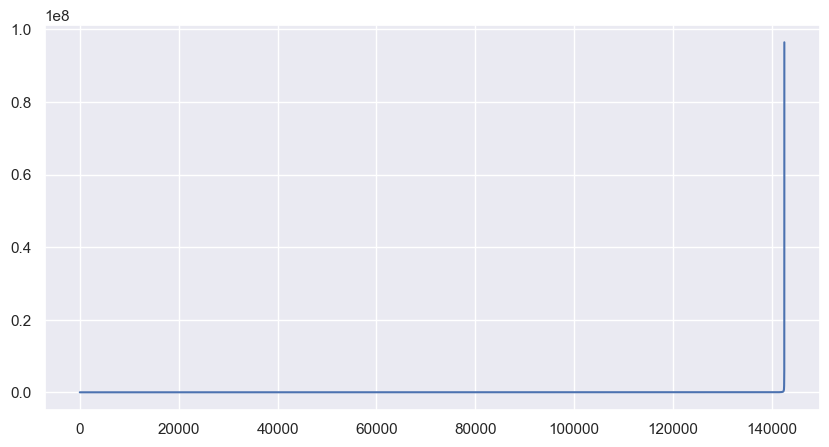

In [185]:
#Applying Knearest Kneighboors to know what eps= parameter is suitable.
from sklearn.neighbors import NearestNeighbors
from datetime import datetime
import time

#First we convert to ordinal type the date to pass into array and fit the model.
df['toordinal'] = df['date'].apply(lambda x: x.toordinal())


neigh = NearestNeighbors(n_neighbors=2)

X=np.array([df.total_sales.values,df.toordinal.values]).T
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)

distances = np.sort(distances, axis=0)
distances = distances[:, 1]
plt.figure(figsize=(10,5))
plt.plot(distances)

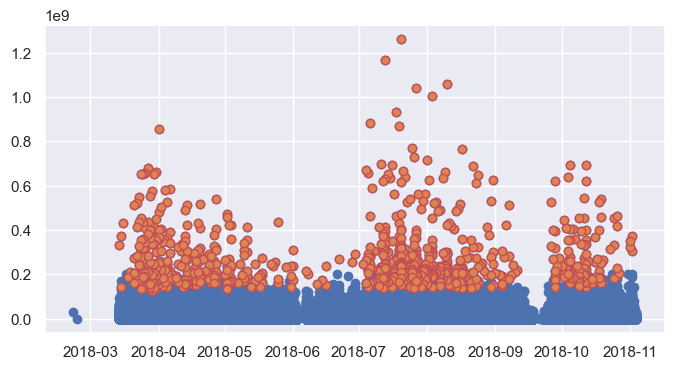

In [188]:
from sklearn.cluster import DBSCAN

# We took 147000 at the maximum curvature to use as epsilon parameter
dbscan = DBSCAN(eps=147000, min_samples=5)
dbscan.fit(df['total_sales'].values.reshape(-1, 1))

labels = dbscan.labels_
df['dbscan_score'] = labels
df_dbscan = df[df['dbscan_score'] < 0]

plt.figure(figsize=(8, 4))
plt.scatter(df.values[:, 11], df.values[:, 3])
dbscan_date = df_dbscan[df_dbscan['total_sales'] > 1].values[:, 11]
dbscan_sales = df_dbscan[df_dbscan['total_sales'] > 1].values[:, 3]
plt.scatter(dbscan_date, dbscan_sales, edgecolor='r')
